In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import scienceplots
import warnings; warnings.filterwarnings("ignore")

import os
import sys; sys.path.append('../')
import numpy as np
from numpy.random import default_rng

import scipy.io as sio
from scipy.stats import wilcoxon
import pysindy as ps
from PDE_FIND import build_linear_system, print_pde, TrainSTRidge
from best_subset import *
from UBIC import *
from skscope_tools import best_subset_solution, abess_solution, best_subset_all_solutions, abess_all_solutions
from solvel0 import solvel0
from sparsity_estimators import Adaptive_Lasso_SS
from sklearn.metrics.pairwise import pairwise_kernels
from ICOMP import *

import sys; sys.path.append('/Users/pongpisitthanasutives/Documents/github/ICOMP/')
from icomp_lm import *
from okridge.solvel0 import *

def evaluate_coefficients(prediected_coeffs):
    GROUND = np.array([0.1, -1])
    errs = 100*np.abs(GROUND-np.array(prediected_coeffs).flatten())/np.abs(GROUND)
    return errs.mean(), errs.std()

Sklearn's version: 1.5.1


#### Load data

In [2]:
data = sio.loadmat('../Datasets/burgers.mat')
u = (data['usol']).real
x = (data['x'][0]).real
t = (data['t'][:,0]).real
dt = t[1]-t[0]
dx = x[2]-x[1]
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

do_plot = False
if do_plot:
    with plt.style.context('ieee'):
        fig = plt.figure(figsize=(8, 8))
        ax = plt.axes(projection='3d')
        ax.plot_surface(X, T, u.T, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
        ax.set_title("Burgers' PDE: $u_{t} = 0.1u_{xx} - uu_{x}$ (unknown)", fontsize = 29.5);
        ax.set_xlabel("x", fontsize = 24)
        ax.set_ylabel("t", fontsize = 24)
        ax.set_zlabel("u", fontsize = 24)
        # fig.savefig("/Users/pongpisit/Downloads/MLSS/overview.pdf")
        # fig.savefig("/Users/pongpisit/Downloads/MLSS/overview.eps")
        # fig.savefig("/Users/pongpisit/Downloads/MLSS/overview.png", dpi=300)
        plt.show()

#### Add noise

In [3]:
print("----- Clean -----")
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

pde_lib = ps.PDELibrary(
    # library_functions=library_functions, 
    # function_names=library_function_names,
    function_library=ps.PolynomialLibrary(degree=2, include_bias=False), 
    derivative_order=2,
    spatial_grid=x,
    is_uniform=True,
)

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=0.1, alpha=1e-5, normalize_columns=False)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(np.expand_dims(u, -1), t=dt)
model.print()

----- Clean -----
STLSQ model: 
(x0)' = 0.100 x0_11 + -1.001 x0x0_1


In [4]:
Ut, R, rhs_des = build_linear_system(u, dt, dx, D=3, P=3, time_diff = 'FD', space_diff = 'FD')
rhs_des = rhs_des[1:]
R = R[:, 1:].real; Ut = Ut.real
w = TrainSTRidge(R,Ut,10**-5,0.1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

print()

print("----- Add 30% noise -----")
np.random.seed(0)
noise_lv = float(30)
print(noise_lv)
noise = 0.01*np.abs(noise_lv)*(u.std())*np.random.randn(u.shape[0],u.shape[1])
un = u + noise
np.mean(noise), np.std(noise), np.max(noise), np.min(noise)

Utn, Rn, rhs_des = build_linear_system(un, dt, dx, D=3, P=3, time_diff = 'poly',
                                       deg_x = 4, deg_t = 4, 
                                       width_x = 10, width_t = 10)
rhs_des = rhs_des[1:]
Rn = Rn[:, 1:].real; Utn = Utn.real
# Solve with STRidge
w = TrainSTRidge(Rn,Utn,10**-5,1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

l0_penalty: 1.6123253173828125
PDE derived using STRidge
u_t = (-1.000403 +0.000000i)uu_{x}
    + (0.100145 +0.000000i)u_{xx}
   

----- Add 30% noise -----
30.0
l0_penalty: 1.93969921875
PDE derived using STRidge
u_t = (-0.775460 +0.000000i)uu_{x}
   


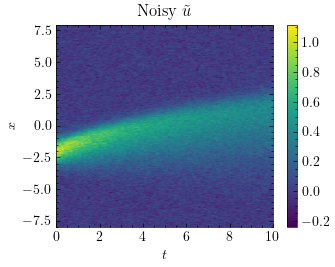

In [5]:
with plt.style.context(['science']):
    ufig, uax = plt.subplots()
    contour = uax.pcolormesh(t, x, un, shading='gouraud')
    uax.set_xlabel("$t$")
    uax.set_ylabel("$x$")
    uax.set_title("Noisy $\Tilde{u}$")
    cbar = ufig.colorbar(contour)
#     ufig.savefig("../Figures/noisy_burgers.pdf")
#     ufig.savefig("../Figures/noisy_burgers.png", dpi=300)
    plt.show()

#### Use the precomputed denoised variable given by the K-SVD

In [6]:
denoised = True
if denoised: un = np.load("./denoised_files/burgers_dictlearn_denoised30_components32_8x8.npy")

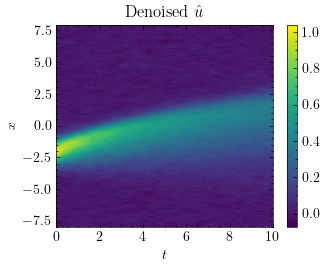

In [7]:
with plt.style.context(['science']):
    ufig, uax = plt.subplots()
    contour = uax.pcolormesh(t, x, un, shading='gouraud')
    uax.set_xlabel("$t$")
    uax.set_ylabel("$x$")
    uax.set_title("Denoised $\hat{u}$")
    cbar = ufig.colorbar(contour)
#     ufig.savefig("../Figures/denoised_burgers.pdf")
#     ufig.savefig("../Figures/denoised_burgers.png", dpi=300)
    plt.show()

#### Applying best-subset regression on the weak formulation

In [8]:
# optimizer = L0BNB(max_nonzeros=2, lam=1e-3, is_normal=True, normalize_columns=False)
# model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, 
#                  differentiation_method=differentiation_method,
#                  feature_names=['u'])
# model.fit(np.expand_dims(un, -1), t=dt)
# model.print()

# best_subsets = [tuple(np.where(abs(brute_force(X_pre, y_pre, support_size=i).flatten())>0)[0]) 
#                 for i in range(1, X_pre.shape[1]+1)]

### Finding where to stop increasing polyorder and difforder

In [9]:
differentiation_method = ps.FiniteDifference; differentiation_kwargs = {}
kwargs = {'copy_X':True, 'normalize_columns':False}
past_best_subsets = None; past_model_names = None
max_poly_deg = 3; max_diff_order = 4
poly_deg = 1; diff_order = 1

while poly_deg <= max_poly_deg and diff_order <= max_diff_order:
    print(poly_deg, diff_order)
    weak_pde_lib = ps.WeakPDELibrary(function_library=ps.PolynomialLibrary(degree=poly_deg, include_bias=False), 
                                     derivative_order=diff_order, 
                                     spatiotemporal_grid=XT, 
                                     include_bias=False, is_uniform=True, K=10000
                                    )

    X_pre, y_pre, fns = ps_features(un, t, weak_pde_lib, kwargs, center_output=False)
    feature_names = weak_pde_lib.get_feature_names()
    mapper = dict(zip(feature_names, range(len(feature_names))))
    
    coefficients, best_subsets = okridge_solvel0_full(X_pre, y_pre, k=X_pre.shape[1])

    print(past_model_names)
    if past_model_names is not None:
        past_best_subsets = [sorted([mapper[feature_name] for feature_name in model_name]) 
                             for model_name in past_model_names]
        # Comparison best_subsets with past_best_subsets
        for i in range(len(past_best_subsets)):
            error = np.linalg.lstsq(X_pre[:, best_subsets[i]], y_pre, rcond=None)[1]
            past_error = np.linalg.lstsq(X_pre[:, past_best_subsets[i]], y_pre, rcond=None)[1]
            if past_error < error:
                best_subsets[i] = past_best_subsets[i]
    
    past_model_names = [set(feature_names[bs[i]] for i in range(len(bs))) for bs in best_subsets]
    
    if diff_order < poly_deg:
        diff_order += 1
    else:
        poly_deg += 1

best_subsets

1 1


100%|██████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.22it/s]


None
2 1


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


[{'x0x0_1'}, {'x0', 'x0x0_1'}, {'x0x0_1', 'x0', 'x0_1'}]
2 2


100%|██████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.49it/s]


[{'x0x0_1'}, {'x0^2', 'x0x0_1'}, {'x0^2x0_1', 'x0^2', 'x0_1'}, {'x0^2x0_1', 'x0^2', 'x0', 'x0_1'}, {'x0^2x0_1', 'x0^2', 'x0', 'x0x0_1', 'x0_1'}]
3 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.03it/s]


[{'x0x0_1'}, {'x0x0_1', 'x0_11'}, {'x0x0_1', 'x0_11', 'x0^2x0_11'}, {'x0^2', 'x0x0_1', 'x0_1', 'x0_11'}, {'x0^2', 'x0', 'x0x0_1', 'x0_1', 'x0_11'}, {'x0^2x0_11', 'x0^2', 'x0', 'x0x0_1', 'x0_1', 'x0_11'}, {'x0^2x0_1', 'x0^2x0_11', 'x0^2', 'x0', 'x0x0_1', 'x0_1', 'x0_11'}, {'x0^2x0_1', 'x0^2x0_11', 'x0^2', 'x0', 'x0x0_1', 'x0_1', 'x0_11', 'x0x0_11'}]
3 3


100%|████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:17<00:00,  1.19s/it]

[{'x0x0_1'}, {'x0x0_1', 'x0_11'}, {'x0x0_1', 'x0_1', 'x0_11'}, {'x0x0_1', 'x0_1', 'x0_11', 'x0^3'}, {'x0^2', 'x0', 'x0x0_1', 'x0_1', 'x0_11'}, {'x0^3x0_11', 'x0^2', 'x0', 'x0x0_1', 'x0_1', 'x0_11'}, {'x0^3x0_1', 'x0^2', 'x0', 'x0_1', 'x0x0_1', 'x0^3', 'x0_11'}, {'x0^2x0_1', 'x0^2', 'x0', 'x0_1', 'x0x0_1', 'x0^3', 'x0_11', 'x0x0_11'}, {'x0^2x0_1', 'x0^2x0_11', 'x0^2', 'x0', 'x0_1', 'x0x0_1', 'x0^3', 'x0_11', 'x0x0_11'}, {'x0^2x0_1', 'x0^3x0_1', 'x0^2x0_11', 'x0^2', 'x0', 'x0_1', 'x0x0_1', 'x0^3', 'x0_11', 'x0x0_11'}, {'x0^2x0_1', 'x0^3x0_11', 'x0^3x0_1', 'x0^2x0_11', 'x0^2', 'x0', 'x0_1', 'x0x0_1', 'x0^3', 'x0_11', 'x0x0_11'}]


[[6],
 [4, 6],
 [2, 4, 6],
 [2, 3, 4, 6],
 [0, 1, 3, 4, 6],
 [0, 1, 3, 4, 6, 11],
 [0, 1, 2, 3, 4, 6, 7],
 [0, 1, 3, 4, 6, 7, 13, 14],
 [0, 1, 3, 4, 5, 6, 7, 13, 14],
 [0, 1, 2, 3, 4, 5, 6, 7, 13, 14],
 [0, 1, 2, 3, 4, 5, 6, 7, 12, 13, 14],
 [0, 1, 2, 3, 4, 5, 6, 7, 10, 12, 13, 14],
 [0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14],
 [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]]

#### Model selection by the UBIC (Algorithm 1)

In [10]:
tau = 3
verbose = True
# scale = 1 <- generalized UBIC
scale = np.log(len(y_pre))
per = 75

# bics = [sm.OLS(y_pre, X_pre[:, bs]).fit().bic for bs in best_subsets]
# aics = [sm.OLS(y_pre, X_pre[:, bs]).fit().aic for bs in best_subsets]
post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre), u_type='cv1', take_sqrt=True)
predictions = X_pre@post_means
print(b_bics)
b_bics = np.array(b_bics)
max_complexity = len(b_bics)
complexities = np.arange(max_complexity)+1
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])
thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
# thres = 0.02
print("threshold:", thres)

lower_bounds = []
for k, efi in enumerate(best_subsets):
    assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    com = len(efi)
    lower_bound = 2*np.abs(log_like_value(predictions[:, k:k+1], y_pre))-np.log(len(y_pre))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
print("max_lam:", last_lam)
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
while now_lam >= 0:
    now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    
    if verbose:
        print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), 
              np.nan_to_num(imp, nan=np.inf))
    
    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = round(last_lam-delta, 8)
    last_ubic = now_ubic
    last_bc = now_bc

best_bc = last_bc
if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
    best_bc = best_bc - 1
    
last_lam = round(last_lam, 8)
last_lam, last_ubic, last_bc, best_bc

[-73100.24411008923, -81783.69985905332, -81832.60821239943, -81928.03654138529, -82012.10976013356, -82104.71845326049, -82114.4213478019, -82130.77088846886, -82145.01540748475, -82150.19962800061, -82150.73274005599, -82148.84992732757, -82140.56862649748, -82131.42781931408, -82122.22644789296]
threshold: 0.0011034515931781824
max_lam: 3.9483910739290184
1 <---> 1 inf
1 <---> 1 inf
1 <---> 5 0.0009813037156561008


(1.31613036,
 array([-72821.57424192, -81592.97555448, -81483.66005954, -81078.6976002 ,
        -80913.27992131, -80497.33880967, -77987.80999225, -78350.00217211,
        -78397.58849944, -77152.49745347, -76975.65062063, -76209.17023538,
        -75475.57340099, -74074.94078216, -62258.02811455]),
 1,
 1)

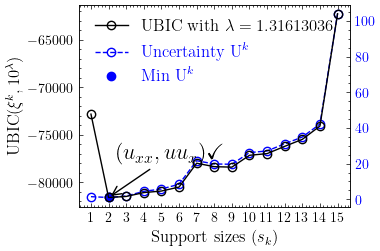

In [11]:
complexity_axis = [len(bs) for bs in best_subsets]
with plt.style.context(['science']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.set_zorder(ax2.get_zorder()+1)
    ax.patch.set_visible(False)
    
    l1, = ax.plot(complexity_axis, last_ubic, 'o-', c='black', markerfacecolor='none', label=f"$\lambda = {abs(last_lam)}$")
    ax.set_xticks(complexity_axis)
    ax.set_ylabel("$\\textrm{UBIC}(\\xi^{k}, 10^{\\lambda})$", fontsize=12)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)
    ax.annotate('$(u_{xx}, uu_{x})\checkmark$', fontsize=16, 
                 xy=(complexity_axis[best_bc], last_ubic[best_bc]), 
                 xytext=(complexity_axis[best_bc]+0.5, last_ubic[best_bc]+4000), 
                 arrowprops={'arrowstyle': '->'})
    
    l2, = ax2.plot(complexity_axis, b_uns, 'o--', c='blue', markerfacecolor='none', label="Uncertainty $\\textrm{U}^{k}$")
    s1 = ax2.scatter(complexity_axis[np.argmin(b_uns)], b_uns[np.argmin(b_uns)], c='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    ax.legend([l1, l2, s1], [f"UBIC with $\lambda = {abs(last_lam)}$", "Uncertainty $\\textrm{U}^{k}$", "Min $\\textrm{U}^{k}$"], 
              labelcolor='linecolor', loc='upper center', fontsize=12)
    
    plt.show()

#### Percent coefficient error

In [12]:
# (0.9107969701290103, 0.3772757947444888)
evaluate_coefficients(np.linalg.lstsq(X_pre[:, best_subsets[best_bc]], 
                                      y_pre, rcond=None)[0].flatten())

(3.497716039419177, 3.1351171433925655)

#### skscope

In [13]:
best_subset_all_solutions(X_pre, y_pre, sparsity=8, normalize_axis=None, refine=1)

(array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        , -0.91339952,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.09336717,
          0.        , -0.99637401,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        , -0.02563745,  0.        ,  0.08858187,
          0.        , -0.99276549,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        , -0.04008387, -0.03636039,  0.08219922,
          0.        , -0.89898306,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        , -0.10227101, -0.04808988,  0.08402382,
          0.        , -0.83976871,

In [14]:
abess_all_solutions(X_pre, y_pre, sparsity=8, normalize_axis=0, refine=1)

(array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -9.13399518e-01,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -2.76553839e-01,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  1.35663733e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -2.09826320e-01,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00, -5.16038597e-01,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  1.10496253e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -1.96498886e-01,  0.00000000

In [15]:
# solvel0(X_pre, y_pre, is_normal=True, max_complexity=8, refine=False)

#### Adaptive_Lasso_SS

In [16]:
from sklearn.utils.random import sample_without_replacement
from sklearn.utils import resample, shuffle

def adaLasso(X,y,magnitude='LS', super_power=2, B=20, EVmax=3, randomized=False, n_alphas=10, eps=3):

    theta_ = np.array(X,dtype=np.float64)
    dt_ = np.array(y,dtype=np.float64)
    normed_dt = dt_/np.linalg.norm(dt_,axis=0,keepdims=True)
    normed_theta = theta_/np.linalg.norm(theta_,axis=0,keepdims=True)

    mask, for_plots= Adaptive_Lasso_SS(normed_theta,normed_dt,
                                       nI = B,
                                       super_power=super_power,
                                       efp=EVmax,
                                       randomized=randomized,n_alphas=n_alphas,
                                       eps=eps)
    
    if magnitude == 'LS':
        coeffs = np.linalg.lstsq(theta_*mask,dt_,rcond=None)[0]
    
    if magnitude == 'Ridge':
        clf = Ridge(alpha=1e-8,fit_intercept=False)
        coeffs = clf.fit(theta_*mask, dt_).coef_

    return coeffs, for_plots

In [17]:
theta, dt = shuffle(X_pre, y_pre, random_state=0)

In [18]:
idx = sample_without_replacement(n_population=theta.shape[0]-1, 
                                 n_samples=1000, 
                                 random_state=42)

X = theta[idx]
y = dt[idx]

xi, for_plots = adaLasso(X,y,magnitude='LS',B=250, super_power=1, n_alphas=20, eps=4, randomized=True)

[tau,piT,pSE,alphas, minLambdaSS, active_set,region] = for_plots

/opt/anaconda3/envs/sindy/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.175e-05, tolerance: 5.615e-06
  model = cd_fast.enet_coordinate_descent(


In [19]:
fig,ax = plt.subplots(1,1,figsize=(7,6))

    
piT = 0.9
efp=8
# average of selected variables
q_hat = tau.sum(axis=1)
# verifying on some upper bound on efp
ev_region = (q_hat)**2/((2*piT-1)*X.shape[1])    
idxS = (ev_region<efp).argmax()   
minLambdaSS = alphas[idxS]
# selecting variables where the efp is respected
active_set = (tau[idxS:,:]>piT).any(axis=0)   

thrs = np.arange(0.51,1,0.001)

E_V_ub = np.stack([(q_hat)**2/((2*piT-1)*X.shape[1]) for piT in thrs])

c=ax.contour(alphas, thrs, E_V_ub,levels=[0,1,2,3,4,8,12],cmap='copper')
cf=ax.contourf(alphas, thrs, E_V_ub,levels=[0,1,2,3,4,8],cmap='Spectral')
ax.clabel(c, inline=True,fmt='%0.0f', fontsize=15)

ax.plot([alphas.min(),alphas.max()],[0.9,0.9],'-.',color='white',linewidth=3)
ax.text(5e-6,0.93,r'$\pi_{thr}=0.9$',color='white')

d=fig.colorbar(cf, ax=ax)
d.set_label(r'$EV_{max}$')

ax.set_xlabel(r'$\lambda$')#, fontsize=font_size)
ax.set_ylabel(r'selection probability $\Pi_{k}^{\lambda}$')


for term in range(X.shape[1]): # here 36 is the number of terms in the library
    if active_set[term]:
        al=1
        ls='-'
        lw=3
    else:
        al=0.3
        ls='--'
        lw=2   
    ax.plot(alphas,tau[:,term],linestyle=ls,alpha=al,linewidth=lw)
    ax.set_xscale('log')

ax.set_title('Randomized Adaptive Lasso')

Text(0.5, 1.0, 'Randomized Adaptive Lasso')

In [20]:
EVmax = 2
# average of selected variables
q_hat = tau.sum(axis=1)
# verifying on some upper bound on efp
ev_region = (q_hat)**2/((2*piT-1)*X.shape[1])    
idxS = (ev_region<EVmax).argmax()   
minLambdaSS = alphas[idxS]
# selecting variables where the efp is respected
active_set = (tau[idxS:,:]>piT).any(axis=0)   

np.where(active_set)[0]  #+1 to match PDE-STRIDE definition

array([3, 4, 7])

In [21]:
# -64826.75240991351 -64826.75226059114
# -74045.09636453557 -74045.09624265385
# -73677.09567195868 -73677.09537848238
# -73131.18137603842 -73131.18098476052
# -73243.81252395896 -73243.81219569719
# -73094.79494380577 -73094.79462249235
# -72730.66487702796 -72730.66448975046
# -73030.4117835024 -73030.41146308606

# alpha = 1e-1
# kics = []
# for bs in best_subsets:
#     K = pairwise_kernels(X_pre[:, list(bs)], metric='rbf')
#     krr = KRR(alpha=alpha).fit(K, y_pre.flatten())
#     kics.append((krr.kic_1, krr.kic_2, krr.pll))
#     print(krr.kic_1, krr.kic_2)

In [22]:
# Input exog, y_pre, a_n

a_n = 1;
idx = 1; exog = X_pre[:, best_subsets[idx]]
m = sm.OLS(y_pre, exog)
m_res = m.fit()
q = m.rank; N = len(y_pre)
rss = np.sum(m_res.resid**2)
S = exog.T@exog
# S_inv = np.linalg.inv(S) # np.linalg.pinv(S, hermitian=True)
S_inv = m_res.cov_params(scale=1) # (scale) * (X.T X)^(-1)

C0 = np.trace(np.log(S_inv))-np.log(np.linalg.det(S_inv))
C1 = q*np.log(np.trace(S_inv)/q)-np.log(np.linalg.det(S_inv))
C_IFIM = (q+1)*np.log((np.trace(S_inv) + 2*rss/N)/(q+1)) - \
            np.log(np.linalg.det(S_inv)) - np.log(2*rss/N)
C_COV = (q+1)*np.log((np.trace(S_inv) + 2*rss*(N-q)/(N**2))/(q+1)) - \
            np.log(np.linalg.det(S_inv)) - np.log(2*rss*(N-q)/(N**2))

C0 = C0*(a_n/2)
C1 = C1*(a_n/2)
C_IFIM = C_IFIM*(a_n/2)
C_COV = C_COV*(a_n/2)

llf = m_res.llf

# 'CO', 'C1', 'IFIM', 'COV'
icomps = (-2*llf + 2*C0, -2*llf + 2*C1, -2*llf + 2*C_IFIM, -2*llf + 2*C_COV)
icomps

(-81802.07626902162,
 -81800.44789252743,
 -81792.33131358432,
 -81792.33111359086)

In [23]:
N = len(y_pre)
beta = np.linalg.lstsq(exog, y_pre)[0]
rss = ((y_pre-exog@beta)**2).sum()
# rss = np.sum(m_res.resid**2)

icomp0 = N*np.log(2*np.pi) + N*np.log(rss/N) + N + 2*C0
icomp1 = N*np.log(2*np.pi) + N*np.log(rss/N) + N + 2*C1
icomp_IFIM = N*np.log(2*np.pi) + N*np.log(rss/N) + N + 2*C_IFIM
icomp_COV = N*np.log(2*np.pi) + N*np.log(rss/N) + N + 2*C_COV
icomps = (icomp0, icomp1, icomp_IFIM, icomp_COV)
icomps

(-81802.07626902162,
 -81800.44789252743,
 -81792.33131358432,
 -81792.33111359086)

In [24]:
# assert C0 - icomp_penalty(S_inv, 'exact') == 0
# # P has rank(P) = n-q
# XX = exog[:100]
# P = XX@np.linalg.inv(XX.T@XX)@(XX.T)
# P = np.eye(len(P))-P
# assert np.linalg.matrix_rank(P, tol=1e-6) == len(XX) - q

In [25]:
# assert np.alltrue(llf_complexity(X_pre[:, (3, 4)], y_pre, a_n=1)[-1] == np.array(icomps))

In [26]:
# Informational complexity criteria for data-driven PDE discovery
# Input exog, y_pre, a_n,
tau = 2
a_n = np.log(len(y_pre))**tau # 1, ..., len(y_pre)
icomps = []
for idx in range(len(best_subsets)):
    exog = X_pre[:, best_subsets[idx]]
    m = sm.OLS(y_pre, exog)
    m_res = m.fit()
    q = m.rank; N = len(y_pre)
    rss = np.sum(m_res.resid**2)
    # S = exog.T@exog
    # S_inv = np.linalg.inv(S) # np.linalg.pinv(S, hermitian=True)
    S_inv = m_res.cov_params(scale=1) # (scale) * (X.T X)^(-1)

    C0 = np.trace(np.log(S_inv))-np.log(np.linalg.det(S_inv))
    C1 = q*np.log(np.trace(S_inv)/q)-np.log(np.linalg.det(S_inv))
    C_IFIM = (q+1)*np.log((np.trace(S_inv) + 2*rss/N)/(q+1)) - \
                np.log(np.linalg.det(S_inv)) - np.log(2*rss/N)
    C_COV = (q+1)*np.log((np.trace(S_inv) + 2*rss*(N-q)/(N**2))/(q+1)) - \
                np.log(np.linalg.det(S_inv)) - np.log(2*rss*(N-q)/(N**2))

    C0 = C0/2
    C1 = C1/2
    C_IFIM = C_IFIM/2
    C_COV = C_COV/2

    llf = m_res.llf

    # 'CO', 'C1', 'IFIM', 'COV'
    icomp = [-2*llf + 2*a_n*C0, -2*llf + 2*a_n*C1, -2*llf + 2*a_n*C_IFIM, -2*llf + 2*a_n*C_COV]
    icomps.append(icomp)
    
icomps = np.array(icomps).T

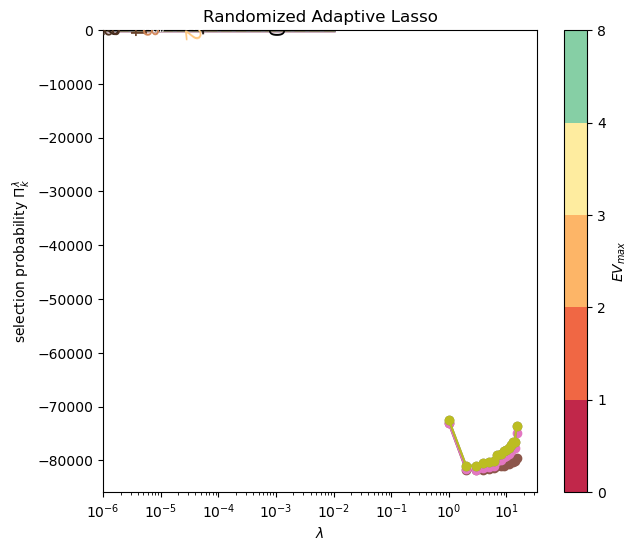

In [27]:
plt.plot(complexities, icomps[0], '-o')
plt.plot(complexities, icomps[1], '-o')
plt.plot(complexities, icomps[2], '-o')
plt.plot(complexities, icomps[3], '-o')
plt.show()

In [28]:
# Informational complexity criteria for data-driven PDE discovery
# Input exog, y_pre, a_n,
a_n = 0.1*len(y_pre) # 1, ..., len(y_pre)
icomps = []
for idx in range(len(best_subsets)):
    exog = X_pre[:, best_subsets[idx]]
    m = sm.OLS(y_pre, exog)
    m_res = m.fit()
    q = m.rank; N = len(y_pre)
    rss = np.sum(m_res.resid**2)
    # S = exog.T@exog
    # S_inv = np.linalg.inv(S) # np.linalg.pinv(S, hermitian=True)
    S_inv = m_res.cov_params(scale=1) # (scale) * (X.T X)^(-1)

    C0 = np.trace(np.log(S_inv))-np.log(np.linalg.det(S_inv))
    C1 = q*np.log(np.trace(S_inv)/q)-np.log(np.linalg.det(S_inv))
    C_IFIM = (q+1)*np.log((np.trace(S_inv) + 2*rss/N)/(q+1)) - \
                np.log(np.linalg.det(S_inv)) - np.log(2*rss/N)
    C_COV = (q+1)*np.log((np.trace(S_inv) + 2*rss*(N-q)/(N**2))/(q+1)) - \
                np.log(np.linalg.det(S_inv)) - np.log(2*rss*(N-q)/(N**2))

    C0 = C0/2
    C1 = C1/2
    C_IFIM = C_IFIM/2
    C_COV = C_COV/2

    llf = m_res.llf

    # 'CO', 'C1', 'IFIM', 'COV'
    icomp = [-2*llf + 2*a_n*C0, -2*llf + 2*a_n*C1, -2*llf + 2*a_n*C_IFIM, -2*llf + 2*a_n*C_COV]
    icomps.append(icomp)
    
icomps = np.array(icomps).T

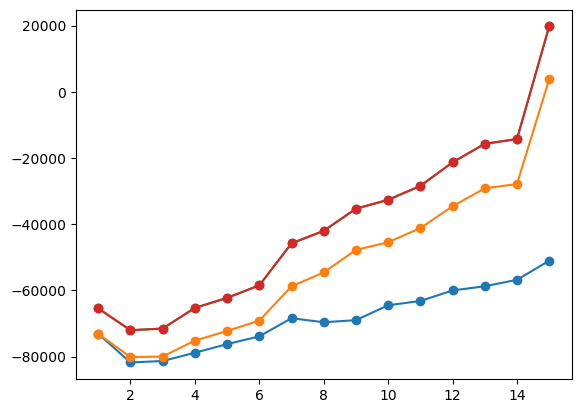

In [29]:
plt.plot(complexities, icomps[0], '-o')
plt.plot(complexities, icomps[1], '-o')
plt.plot(complexities, icomps[2], '-o')
plt.plot(complexities, icomps[3], '-o')
plt.show()

9.210340371976184
12
6


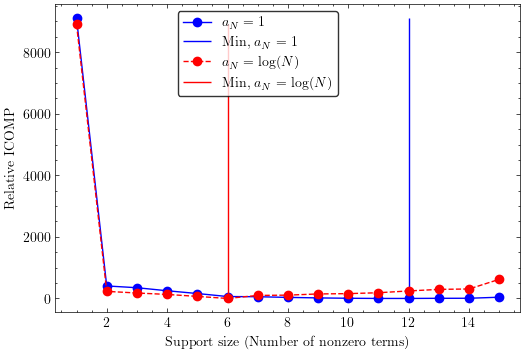

In [30]:
icomp_idx = 2
print(np.log(len(y_pre)))

rel_icomps_1 = []
for bs in best_subsets:
    llf, CM, icomp = llf_complexity(X_pre[:, bs], y_pre, a_n=1)
    rel_icomps_1.append(icomp[icomp_idx])
rel_icomps_1 = np.array(rel_icomps_1)-min(rel_icomps_1)
print(np.argmin(rel_icomps_1)+1)

rel_icomps_log = []
CMs = []
for bs in best_subsets:
    llf, CM, icomp = llf_complexity(X_pre[:, bs], y_pre, a_n=np.log(len(y_pre)))
    CMs.append(CM[icomp_idx])
    rel_icomps_log.append(icomp[icomp_idx])
rel_icomps_log = np.array(rel_icomps_log)-min(rel_icomps_log)
print(np.argmin(rel_icomps_log)+1)

with plt.style.context(['science']):
    plt.figure(figsize=(6, 4))
    plt.plot(complexities, rel_icomps_1, '-o', c='blue', label="$a_{N}=1$")
    plt.vlines(np.argmin(rel_icomps_1)+1, min(rel_icomps_1), max(rel_icomps_1), color='blue', label="Min, $a_{N}=1$")
    plt.plot(complexities, rel_icomps_log, '--o', c='red', label="$a_{N}=\log(N)$")
    plt.vlines(np.argmin(rel_icomps_log)+1, min(rel_icomps_log), max(rel_icomps_log), color='red', label="Min, $a_{N}=\log(N)$")
    plt.xlabel("Support size (Number of nonzero terms)")
    plt.ylabel("Relative ICOMP")
    plt.legend(loc='upper center', bbox_to_anchor=(0.435, 1), frameon=True, edgecolor='black')
    # plt.savefig("/Users/pongpisitthanasutives/Documents/latex/UBIC-proof-arxiv/Figure/icomp_comparison.pdf")
    # plt.savefig("/Users/pongpisitthanasutives/Documents/MLSS/icomp_comparison.pdf")
    # plt.savefig("/Users/pongpisitthanasutives/Documents/MLSS/icomp_comparison.png", dpi=300)
    plt.show()

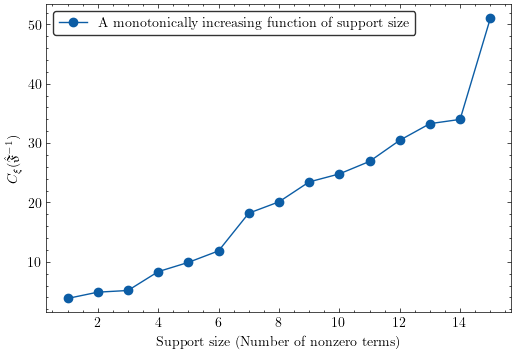

In [31]:
with plt.style.context(['science']):
    plt.figure(figsize=(6, 4))
    plt.plot(complexities, CMs, '-o', label='A monotonically increasing function of support size')
    plt.ylabel("$C_{\\xi}(\hat{\mathfrak{F}}^{-1})$")
    plt.xlabel("Support size (Number of nonzero terms)")
    plt.legend(frameon=True, edgecolor='black')
    plt.savefig("/Users/pongpisitthanasutives/Documents/latex/UBIC-proof-arxiv/Figure/ifim.pdf")
    plt.show()

#### Let's tune ICOMP

In [32]:
n_resample = 30
n_samples = 1000
v_icomps = []
for bs in best_subsets:
    icomps = []
    for _ in range(n_resample):
        idx = sample_without_replacement(n_population=theta.shape[0]-1, n_samples=n_samples, random_state=_)
        X_resample, y_resample = theta[idx], dt[idx]
        X_resample = X_resample[:, bs]
        llf, CM, icomp = llf_complexity(X_resample, y_resample)
        icomp = icomp[2]
        icomps.append(icomp)
    v_icomps.append(icomps)
v_icomps = np.array(v_icomps)
v_icomps_ranking = np.argsort(v_icomps.sum(axis=-1))

for i in range(1, len(best_subsets)):
    wres = wilcoxon(v_icomps[i], v_icomps[i-1], alternative='less')
    print(wres.pvalue)

9.313225746154785e-10
0.0009320033714175224
1.0
0.999999969266355
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [33]:
a_n = np.log(len(y_pre))
CMs = []; llfs = []
for bs in best_subsets: 
    llf, CM, _ = llf_complexity(X_pre[:, bs], y_pre)
    CM = CM[2]
    CMs.append(CM)
    llfs.append(llf)
llfs = np.array(llfs); CMs = np.array(CMs)
last_icomps, last_bc = icomp_ic(llfs, CMs, a_n)
icomps = last_icomps.copy()
per = 75
d_complexities = complexities[decreasing_values_indices(icomps)]
d_icomps = icomps[decreasing_values_indices(icomps)]
thres = np.percentile(np.abs(np.diff(d_icomps)/(np.diff(d_complexities)*d_icomps[:-1])), per)
print("Threshold", thres)
pthres = 0.01
print("P-Threshold", pthres)

num_an = 4
a_ns = np.log(len(y_pre))**np.linspace(1, np.log((llfs/CMs).max()), num_an)
for a_n in a_ns[1:]:
    now_icomp, now_bc = icomp_ic(llfs, CMs, a_n)
    
    diff_com = now_bc-last_bc
    diff_icomp = icomps[now_bc]-icomps[last_bc]
    imp = abs(diff_icomp/(icomps[min(last_bc, now_bc)]*diff_com))
    diff_v_icomp = v_icomps[now_bc]-v_icomps[last_bc]
    pvalue_pos, pvalue_neg, pvalue_adj = np.nan, np.nan, np.nan
    adj_coms = v_icomps_ranking[v_icomps_ranking<now_bc]
    if not np.array_equal(diff_v_icomp, np.zeros(len(diff_v_icomp))):
        pvalue_pos = wilcoxon(diff_v_icomp, alternative='less').pvalue
        pvalue_neg = wilcoxon(-diff_v_icomp, alternative='less').pvalue
        if len(adj_coms) != 0:
            pvalue_adj = wilcoxon(v_icomps[now_bc]-v_icomps[adj_coms[0]], alternative='less').pvalue

    if verbose:
        print(last_bc, '--->', now_bc, 
              np.nan_to_num(imp, nan=np.inf), 
              np.nan_to_num(pvalue_pos, nan=np.inf), 
              np.nan_to_num(pvalue_neg, nan=np.inf))
    
    ### Old version ###
    # if (diff_com > 0 and (diff_icomp > 0 or imp <= thres)) or \
    #     (diff_com < 0 and diff_icomp > 0 and imp >= thres):
    #     break
    
    if (diff_com > 0 and (diff_icomp > 0 or pvalue_pos > pthres or pvalue_adj > pthres)) or \
        (diff_com < 0 and diff_icomp > 0 and pvalue_neg <= pthres):
        break
    
    last_an = a_n
    last_icomps = now_icomp
    last_bc = now_bc
    
last_an, last_icomps, last_bc

Threshold 0.0008086468340125809
P-Threshold 0.01
5 ---> 1 0.0007031541711685303 9.313225746154785e-10 1.0
1 ---> 0 0.11874761751284914 1.0 9.313225746154785e-10


(3870.1668201196885,
 array([-43411.77994559, -43917.04558255, -41786.07581868, -17349.54998261,
         -5336.28567277,   9525.48606898,  58670.89838286,  73426.75242719,
         99376.51101676, 109802.01231521, 126102.20415267, 153632.64554597,
        175325.47284549, 180860.07134718, 312489.57701269]),
 1)

#### PLAY ####

In [34]:
now_bc = 0; last_bc = 1
# now_bc = 1; last_bc = 0
diff_com = now_bc-last_bc
diff_v_icomp = v_icomps[now_bc]-v_icomps[last_bc]
pthres = 0.01
if diff_com > 0:
    # now_bc > last_bc but not sig improvement from last_bc to now_bc -> break
    wres = wilcoxon(diff_v_icomp, alternative='less')
    pvalue = wres.pvalue
    if pvalue > pthres:
        print("not sig")
elif diff_com < 0:
    # now_bc < last_bc but last_bc was already sig better than now_bc
    wres = wilcoxon(-diff_v_icomp, alternative='less')
    pvalue = wres.pvalue
    if pvalue <= pthres:
        print("not sig")
pvalue

not sig


9.313225746154785e-10